<a href="https://colab.research.google.com/github/Berkay86/DeepPerson/blob/main/CHESS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded chessboard.png (812px x 812px)


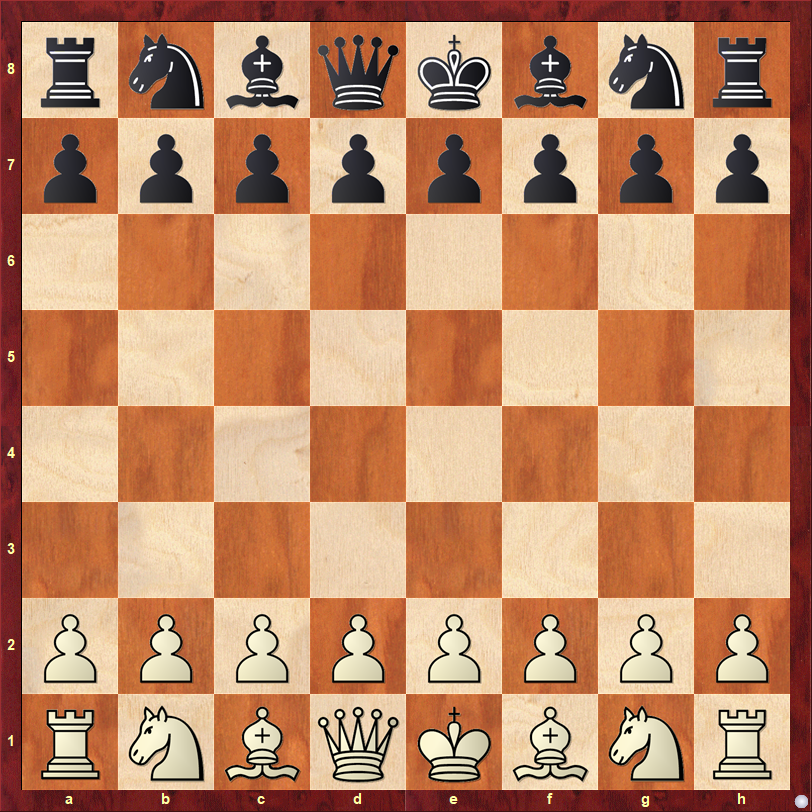

In [12]:
import numpy as np
import cv2
import PIL.Image

# Define a helper function for displaying images
def display_array(a, fmt='jpeg', rng=[0,255]):
    a = np.uint8(np.clip(a, *rng))
    PIL.Image.fromarray(a).show()

# File
# img_file = 'img1.png'
# img_file = 'img2.png'
# img_file = 'img3.gif'
# img_file = 'img4.jpg'
# img_file = 'img7.png'
# img_file = 'img9.png' # Doesn't work anymore due to non-alternating checkerboard linesi
# img_file = 't1.png'
img_file = 'chessboard.png'
# img_file = 'lichess_5.png'

# folder = "chessboards/input_chessboards"
# folder = "chessboards/test_chessboards"
folder = "."

img = PIL.Image.open("%s/%s" % (folder,img_file)).convert('RGB')

print ("Loaded %s (%dpx x %dpx)" % (img_file, img.size[0], img.size[1]))

# Resize if image larger than 2k pixels on a side
if img.size[0] > 2000 or img.size[1] > 2000:
    print ("Image too big (%d x %d)" % (img.size[0], img.size[1]))
    new_size = 500.0 # px
    if img.size[0] > img.size[1]:
        # resize by width to new limit
        ratio = new_size / img.size[0]
    else:
        # resize by height
        ratio = new_size / img.size[1]
    print( "Reducing by factor of %.2g" % (1./ratio))
    img = img.resize(img.size * ratio, PIL.Image.ADAPTIVE)
    print ("New size: (%d x %d)" % (img.size[0], img.size[1]))
    
# See original image
display_array(np.asarray(img), rng=[0,255])


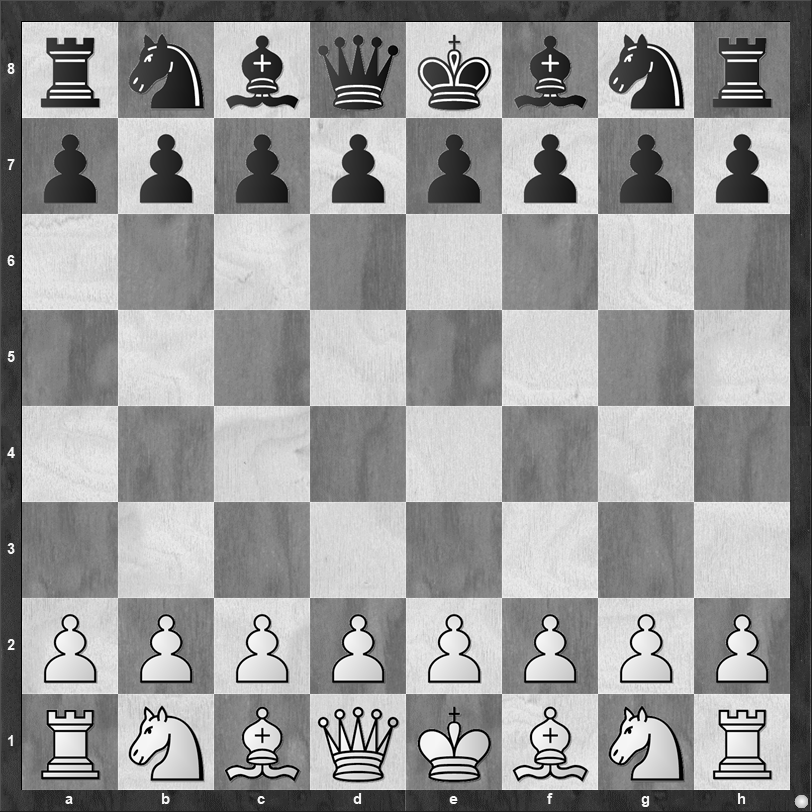

In [13]:
# Convert to grayscale and array
a = np.asarray(img.convert("L"), dtype=np.float32)

# Display array
display_array(a, rng=[0,255])

In [14]:
def make_kernel(a):
  """Transform a 2D array into a convolution kernel"""
  a = np.asarray(a)
  a = a.reshape(list(a.shape) + [1,1])
  return tf.constant(a, dtype=1)

def simple_conv(x, k):
  """A simplified 2D convolution operation"""
  x = tf.expand_dims(tf.expand_dims(x, 0), -1)
  y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
  return y[0, :, :, 0]

def gradientx(x):
  """Compute the x gradient of an array"""
  gradient_x = make_kernel([[-1.,0., 1.],
                            [-1.,0., 1.],
                            [-1.,0., 1.]])
  return simple_conv(x, gradient_x)

def gradienty(x):
  """Compute the x gradient of an array"""
  gradient_y = make_kernel([[-1., -1, -1],[0.,0,0], [1., 1, 1]])
  return simple_conv(x, gradient_y)

def corners(x):
  """Find chess square corners in an array"""
  chess_corner = make_kernel([[-1., 0, 1],[0., 0., 0.], [1.,0, -1]])
  return simple_conv(x, chess_corner)

# Following are meant for binary images
def dilate(x, size=3):
  """Dilate"""
  kernel = make_kernel(np.ones([size,size], dtype=np.float32))
  return tf.clip_by_value(simple_conv(x, kernel),
                          np.float32(1),
                          np.float32(2))-np.float32(1)

def erode(x, size=3):
  """Erode"""
  kernel = make_kernel(np.ones([size,size]))
  return tf.clip_by_value(simple_conv(x, kernel),
                          np.float32(size*size-1),
                          np.float32(size*size))-np.float32(size*size-1)

def opening(x, size=3):
    return dilate(erode(x,size),size)

def closing(x, size=3):
    return erode(dilate(x,size),size)

def skeleton(x, size=3):
    """Skeletonize"""
    return tf.clip_by_value(erode(x) - opening(erode(x)),
                            0.,
                            1.)

In [16]:
# Get our grayscale image matrix
import tensorflow.compat.v1 as tf
A = tf.Variable(a)

# Get X & Y gradients and subtract opposite gradient
# Strongest response where gradient is unidirectional
# clamp into range 0-1
Dx = tf.clip_by_value(np.abs(gradientx(A)) - np.abs(gradienty(A)), 0., 1.)
Dy = tf.clip_by_value(np.abs(gradienty(A)) - np.abs(gradientx(A)),0., 1.)

Dx = gradientx(A)
Dy = gradienty(A)

Dxy = np.abs(gradientx(A) * gradienty(A))
Dc = np.abs(corners(A))

In [18]:
# Initialize state to initial conditions
import tensorflow.compat.v1 as tf
tf.compat.v1.global_variables_initializer()

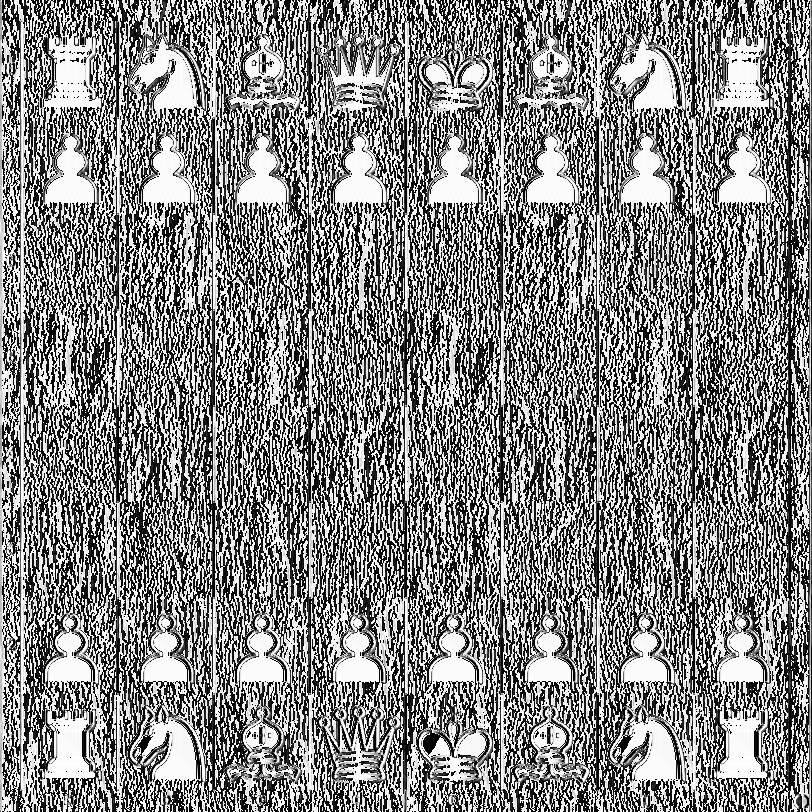

--------------------------------------------------------------------------------------------


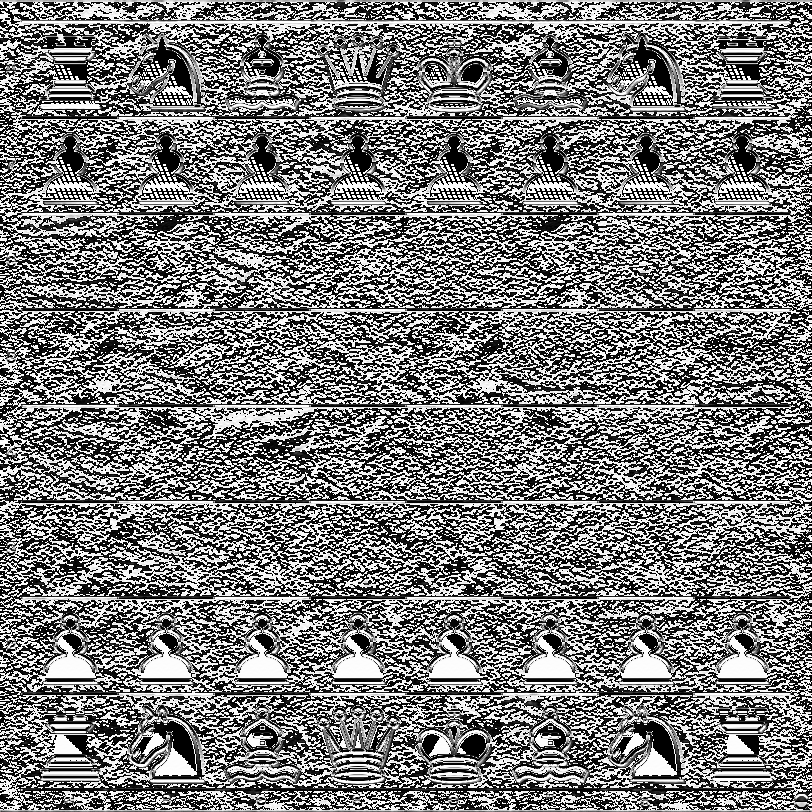

In [23]:
import tensorflow.compat.v1 as tf
display_array(Dx.numpy(), rng=[-255,255])
print("--------------------------------------------------------------------------------------------")
display_array(Dy.numpy(), rng=[-255,255])

In [24]:
Dx_pos = tf.clip_by_value(Dx, 0., 255., name="dx_positive")
Dx_neg = tf.clip_by_value(Dx, -255., 0., name='dx_negative')
Dy_pos = tf.clip_by_value(Dy, 0., 255., name="dy_positive")
Dy_neg = tf.clip_by_value(Dy, -255., 0., name='dy_negative')

In [25]:
hough_Dx = tf.reduce_sum(Dx_pos, 0) * tf.reduce_sum(-Dx_neg, 0) / (a.shape[0]*a.shape[0])
hough_Dy = tf.reduce_sum(Dy_pos, 1) * tf.reduce_sum(-Dy_neg, 1) / (a.shape[1]*a.shape[1])
# Normalized to 0-255*255=65025 range

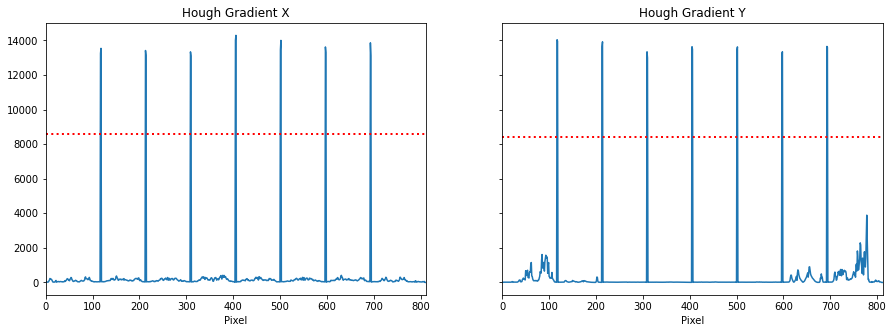

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(15,5))

# Arbitrarily choose half of max value as threshold, since they're such strong responses
hough_Dx_thresh = tf.reduce_max(hough_Dx) * 3 / 5
hough_Dy_thresh = tf.reduce_max(hough_Dy) * 3 /5

ax1.plot(hough_Dx.numpy());
ax1.axhline(hough_Dx_thresh.numpy(), lw=2,linestyle=':',color='r')
ax1.set_title('Hough Gradient X')
ax1.set_xlabel('Pixel')
ax1.set_xlim(0,a.shape[1])

ax2.plot(hough_Dy.numpy())
ax2.axhline(hough_Dy_thresh.numpy(), lw=2,linestyle=':',color='r')
ax2.set_title('Hough Gradient Y')
ax2.set_xlim(0,a.shape[0])
ax2.set_xlabel('Pixel');

In [30]:
def checkMatch(lineset):
    """Checks whether there exists 7 lines of consistent increasing order in set of lines"""
    linediff = np.diff(lineset)
    x = 0
    cnt = 0
    for line in linediff:
        # Within 5 px of the other (allowing for minor image errors)
        if np.abs(line - x) < 5:
            cnt += 1
        else:
            cnt = 0
            x = line
    return cnt == 5

def pruneLines(lineset):
    """Prunes a set of lines to 7 in consistent increasing order (chessboard)"""
    linediff = np.diff(lineset)
    x = 0
    cnt = 0
    start_pos = 0
    for i, line in enumerate(linediff):
        # Within 5 px of the other (allowing for minor image errors)
        if np.abs(line - x) < 5:
            cnt += 1
            if cnt == 5:
                end_pos = i+2
                return lineset[start_pos:end_pos]
        else:
            cnt = 0
            x = line
            print (i, x)
            start_pos = i
    return lineset

def skeletonize_1d(arr):
    """return skeletonized 1d array (thin to single value, favor to the right)"""
    _arr = arr.copy() # create a copy of array to modify without destroying original
    # Go forwards
    for i in range(_arr.size-1):
        # Will right-shift if they are the same
        if arr[i] <= _arr[i+1]:
            _arr[i] = 0
    
    # Go reverse
    for i in np.arange(_arr.size-1, 0,-1):
        if _arr[i-1] > _arr[i]:
            _arr[i] = 0
    return _arr

def getChessLines(hdx, hdy, hdx_thresh, hdy_thresh):
    """Returns pixel indices for the 7 internal chess lines in x and y axes"""
    # Blur
    gausswin = scipy.signal.gaussian(21,4)
    gausswin /= np.sum(gausswin)

    # Blur where there is a strong horizontal or vertical line (binarize)
    blur_x = np.convolve(hdx > hdx_thresh, gausswin, mode='same')
    blur_y = np.convolve(hdy > hdy_thresh, gausswin, mode='same')


    skel_x = skeletonize_1d(blur_x)
    skel_y = skeletonize_1d(blur_y)

    # Find points on skeletonized arrays (where returns 1-length tuple)
    lines_x = np.where(skel_x)[0] # vertical lines
    lines_y = np.where(skel_y)[0] # horizontal lines
    
    # Prune inconsistent lines
    lines_x = pruneLines(lines_x)
    lines_y = pruneLines(lines_y)
    
    is_match = len(lines_x) == 7 and len(lines_y) == 7 and checkMatch(lines_x) and checkMatch(lines_y)
    
    return lines_x, lines_y, is_match

# Get chess lines
lines_x, lines_y, is_match = getChessLines(hough_Dx.numpy().flatten(), \
                                           hough_Dy.numpy().flatten(), \
                                           hough_Dx_thresh.numpy(), \
                                           hough_Dy_thresh.numpy())

lines_x, lines_y, is_match = getChessLines(hough_Dx.numpy().flatten(), \
                                           hough_Dy.numpy().flatten(), \
                                           hough_Dx_thresh.numpy()*.9, \
                                           hough_Dy_thresh.numpy()*.9)

print ("X",lines_x, np.diff(lines_x))
print ("Y",lines_y, np.diff(lines_y))
if is_match:
    print( "Chessboard found")
else:
    print ("Couldn't find Chessboard")

0 96
0 96
0 96
0 96
X [118 214 310 406 502 598 694] [96 96 96 96 96 96]
Y [118 214 310 406 502 598 694] [96 96 96 96 96 96]
Chessboard found


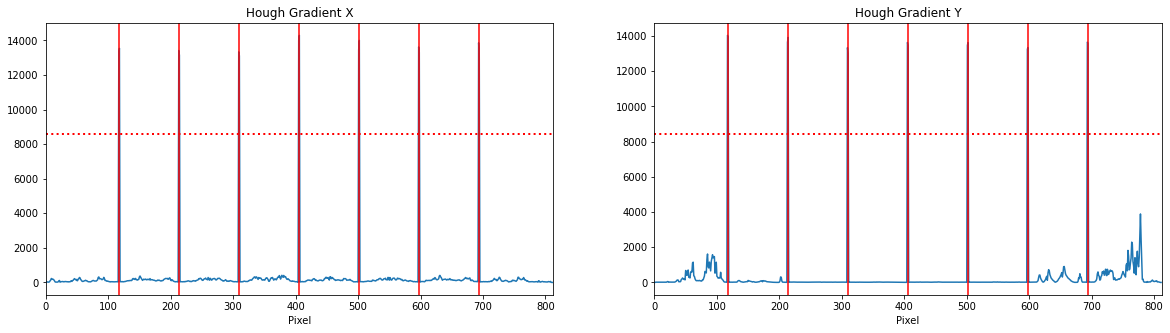

In [32]:
# Plot blurred 1d hough arrays and skeletonized versions
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))

ax1.plot(hough_Dx.numpy());
ax1.axhline(hough_Dx_thresh.numpy(), lw=2,linestyle=':',color='r')
ax1.set_title('Hough Gradient X')
ax1.set_xlabel('Pixel')
ax1.set_xlim(0,a.shape[1])

ax2.plot(hough_Dy.numpy())
ax2.axhline(hough_Dy_thresh.numpy(), lw=2,linestyle=':',color='r')
ax2.set_title('Hough Gradient Y')
ax2.set_xlim(0,a.shape[0])
ax2.set_xlabel('Pixel');

# Plot lines for where peaks where found
if len(lines_x < 20):
    for hx in lines_x:
        ax1.axvline(hx,color='r')
if len(lines_y < 20):
    for hy in lines_y:
        ax2.axvline(hy,color='r')

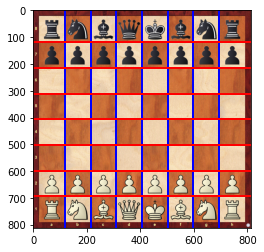

In [33]:
plt.imshow(img)
for hx in lines_x:
    plt.axvline(hx, color='b', lw=2)

for hy in lines_y:
    plt.axhline(hy, color='r', lw=2)

In [36]:
print ("X   (vertical)",lines_x, np.diff(lines_x))
print ("Y (horizontal)",lines_y, np.diff(lines_y))

def getChessTiles(a, lines_x, lines_y):
    """Split up input grayscale array into 64 tiles stacked in a 3D matrix using the chess linesets"""
    # Find average square size, round to a whole pixel for determining edge pieces sizes
    stepx = np.int32(np.round(np.mean(np.diff(lines_x))))
    stepy = np.int32(np.round(np.mean(np.diff(lines_y))))
    
    # Pad edges as needed to fill out chessboard (for images that are partially over-cropped)
#     print stepx, stepy
#     print "x",lines_x[0] - stepx, "->", lines_x[-1] + stepx, a.shape[1]
#     print "y", lines_y[0] - stepy, "->", lines_y[-1] + stepy, a.shape[0]
    padr_x = 0
    padl_x = 0
    padr_y = 0
    padl_y = 0
    
    if lines_x[0] - stepx < 0:
        padl_x = np.abs(lines_x[0] - stepx)
    if lines_x[-1] + stepx > a.shape[1]-1:
        padr_x = np.abs(lines_x[-1] + stepx - a.shape[1])
    if lines_y[0] - stepy < 0:
        padl_y = np.abs(lines_y[0] - stepy)
    if lines_y[-1] + stepx > a.shape[0]-1:
        padr_y = np.abs(lines_y[-1] + stepy - a.shape[0])
    
    # New padded array
#     print "Padded image to", ((padl_y,padr_y),(padl_x,padr_x))
    a2 = np.pad(a, ((padl_y,padr_y),(padl_x,padr_x)), mode='edge')
    
    setsx = np.hstack([lines_x[0]-stepx, lines_x, lines_x[-1]+stepx]) + padl_x
    setsy = np.hstack([lines_y[0]-stepy, lines_y, lines_y[-1]+stepy]) + padl_y
    
    a2 = a2[setsy[0]:setsy[-1], setsx[0]:setsx[-1]]
    setsx -= setsx[0]
    setsy -= setsy[0]
#     display_array(a2, rng=[0,255])    
#     print "X:",setsx
#     print "Y:",setsy
    
    # Matrix to hold images of individual squares (in grayscale)
#     print "Square size: [%g, %g]" % (stepy, stepx)
    squares = np.zeros([np.round(stepy), np.round(stepx), 64],dtype=np.uint8)
    
    # For each row
    for i in range(0,8):
        # For each column
        for j in range(0,8):
            # Vertical lines
            x1 = setsx[i]
            x2 = setsx[i+1]
            padr_x = 0
            padl_x = 0
            padr_y = 0
            padl_y = 0

            if (x2-x1) > stepx:
                if i == 7:
                    x1 = x2 - stepx
                else:
                    x2 = x1 + stepx
            elif (x2-x1) < stepx:
                if i == 7:
                    # right side, pad right
                    padr_x = stepx-(x2-x1)
                else:
                    # left side, pad left
                    padl_x = stepx-(x2-x1)
            # Horizontal lines
            y1 = setsy[j]
            y2 = setsy[j+1]

            if (y2-y1) > stepy:
                if j == 7:
                    y1 = y2 - stepy
                else:
                    y2 = y1 + stepy
            elif (y2-y1) < stepy:
                if j == 7:
                    # right side, pad right
                    padr_y = stepy-(y2-y1)
                else:
                    # left side, pad left
                    padl_y = stepy-(y2-y1)
            # slicing a, rows sliced with horizontal lines, cols by vertical lines so reversed
            # Also, change order so its A1,B1...H8 for a white-aligned board
            # Apply padding as defined previously to fit minor pixel offsets
            squares[:,:,(7-j)*8+i] = np.pad(a2[y1:y2, x1:x2],((padl_y,padr_y),(padl_x,padr_x)), mode='edge')
    return squares

if is_match:
    # Possibly check np.std(np.diff(lines_x)) for variance etc. as well/instead
    print ("7 horizontal and vertical lines found, slicing up squares")
    squares = getChessTiles(a, lines_x, lines_y)
    print ("Tiles generated: (%dx%d)*%d" , (squares.shape[0], squares.shape[1], squares.shape[2]))
else:
    print ("Number of lines not equal to 7")

X   (vertical) [118 214 310 406 502 598 694] [96 96 96 96 96 96]
Y (horizontal) [118 214 310 406 502 598 694] [96 96 96 96 96 96]
7 horizontal and vertical lines found, slicing up squares
Tiles generated: (%dx%d)*%d (96, 96, 64)


Order is row-wise from top left of image going right and down, so a8,b8....a7,b7,c7...h1
Showing 5 random squares...
#%d: %s%d (36, 'E', 5.5)


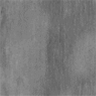

#%d: %s%d (3, 'D', 1.375)


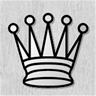

#%d: %s%d (49, 'B', 7.125)


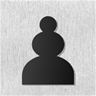

#%d: %s%d (45, 'F', 6.625)


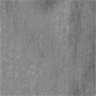

#%d: %s%d (14, 'G', 2.75)


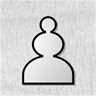

In [38]:
letters = 'ABCDEFGH'

if is_match:
    print ("Order is row-wise from top left of image going right and down, so a8,b8....a7,b7,c7...h1")
    print ("Showing 5 random squares...")
    for i in np.random.choice(np.arange(64),5,replace=False):
        print ("#%d: %s%d" , (i, letters[i%8], i/8+1))
        display_array(squares[:,:,i],rng=[0,255])
else:
    print ("Didn't have lines to slice image up.")